# Add together some light curves like a binary

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from kepler_data import load_kepler_data
from astropy.stats import LombScargle

plotpar = {'axes.labelsize': 25,
           'font.size': 25,
           'legend.fontsize': 25,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [2]:
kids = pd.read_csv("../data/kids_with_lcs.txt")

In [3]:
lc_dir = "/Users/ruthangus/.kplr/data/lightcurves/{}".format(str(kids.KIC[0]).zfill(9))
x0, y0, yerr0, cadence0 = load_kepler_data(lc_dir)
m = x0 < 350
m &= 300 < x0
x0, y0 = x0[m], y0[m]

lc_dir = "/Users/ruthangus/.kplr/data/lightcurves/{}".format(str(kids.KIC[1]).zfill(9))
x1, y1, yerr1, cadence1 = load_kepler_data(lc_dir)
m = x1 < 350
m &= 300 < x1
x1, y1 = x1[m], y1[m]

y3 = y1+y0[:len(y1)]

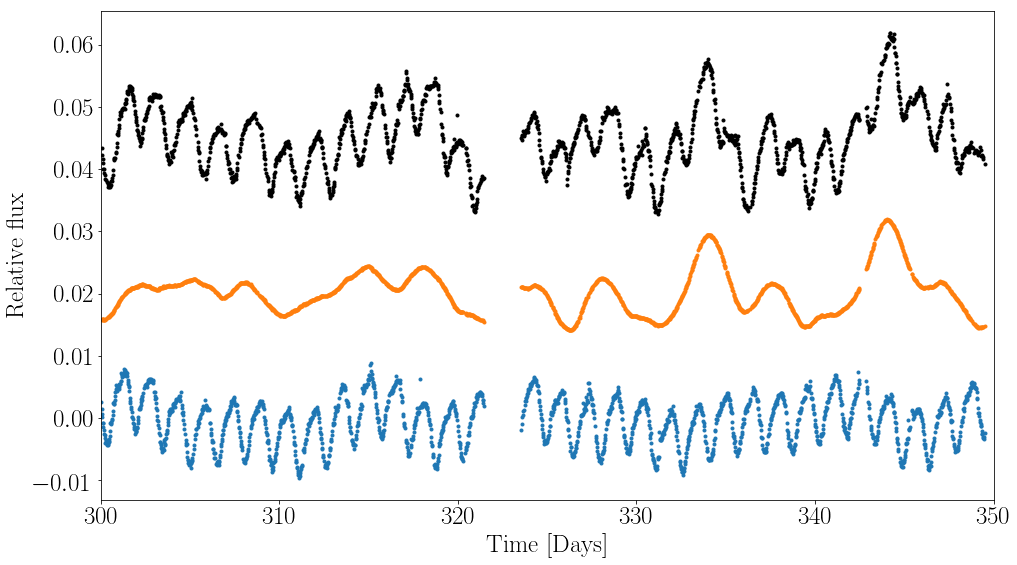

In [4]:
plt.figure(figsize=(16, 9))
plt.plot(x0, y0, ".")
plt.plot(x1, y1+.02, ".")
plt.plot(x1, y3 + .045, "k.")
plt.xlim(300, 350)
plt.ylabel("$\mathrm{Relative~flux}$")
plt.xlabel("$\mathrm{Time~[Days]}$")
# plt.ylim(-.015, .035)
plt.savefig("../plots/two_light_curves.pdf")
plt.savefig("../plots/two_light_curves")

(0, 10)

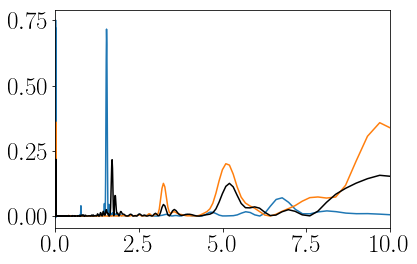

In [5]:
frequency0, power0 = LombScargle(x0, y0).autopower()
plt.plot(1./frequency0, power0)

frequency1, power1 = LombScargle(x1, y1).autopower()
plt.plot(1./frequency1, power1)

frequency01, power01 = LombScargle(x1, y3).autopower()
plt.plot(1./frequency01, power01, "k")

plt.xlim(0, 10)

Now make some general code for adding together stellar light curves.

Specify how many singles and how many doubles you want.
How many days-worth of data do you need?
Download single and double light curves to specified directory.

Choose two stars at random

Download their light curves

Load the data.

Add together the light curves

In [22]:
import numpy as np
import kplr
client = kplr.API()
import pandas as pd
import os

def assemble_data(N, ftrain=.8, fdouble=.5, ndays=70, path="."):
    """
    Code for downloading a training set for Kepler binary project.
    params:
    -------
    N: (int)
        The total number of stars light curves to download.
    ftrain: (float)
        The fraction of stars to train on. (1-ftrain) is the fraction of test stars. default is 0.8.
        Must be between 0 and 1.
    fdouble: (float)
        The fraction of "double" stars you want. (some of these might be triples or quadruples!)
        Must be between 0 and 1. Default is 0.5. fsingle = 1-fdouble.
    ndays: (int)
        The number of days of light curves to download. Default is 70.
    path: str
        The path to the directory you'd like the data to be saved in. default is current directory.
        Two subdirectories will be created containing single and double light curves.
    """
    
    df = pd.read_csv("../data/KICs.csv")
    kids = df.KIC.values
    np.random.shuffle(kids)
    kids = kids[:N]
    
    ntrain = int(N*ftrain)
    print(N, "stars")
    print(ntrain, "for training")
    
    # Create the directories for saving data
    dirname = "{0}/train/".format(path)
    if not os.path.exists(dirname):
        os.mkdir(dirname)
        print("Directory " , dirname ,  " Created ")
    
    dirname = "{0}/test/".format(path)
    if not os.path.exists(dirname):
        os.mkdir(dirname)
        print("Directory " , dirname ,  " Created ")
    
    # Allocated indices for splitting train and test.
    inds = np.arange(N)
    np.random.seed(42)
    np.random.shuffle(inds)
    training_inds = inds[:ntrain]
    testing_inds = inds[ntrain:]
    
    training_ids = df.KIC.iloc[training_inds]
    make_singles_and_doubles(training_ids.values, "train", ndays, path=path)
    
    assert 0
    testing_ids = df.KIC.iloc[testing_inds]
    make_singles_and_doubles(testing_ids.values, "test", ndays, path=path)

    
def make_singles_and_doubles(ids, train_or_test, ndays, fdouble=.5,
                             path=".", lc_dir="/Users/ruthangus/.kplr/data/lightcurves"):
    """
    params:
    -------
    ids: list or array
        The KIC ids to create light curves from.
    train_or_test: str
        The directory in which to save the resulting light curves.
    """
    ntrain = len(ids)
    
    # Make sure there is an even number of stars to create doubles from
    ndouble = int(ntrain * fdouble)
    if ndouble % 2:
        ndouble -= 1
        
    double_ids = ids[:ndouble]
    single_ids = ids[ndouble:]
    print(ndouble, "doubles, ", len(single_ids), "singles")
        
    for j, i in enumerate(np.arange(0, len(double_ids), 2)):  # double stars for training.
        print("double stars ", i, "and", i+1)
        print("single star", j)
        print("id 1 = ", str(double_ids[i]).zfill(9))
        print("id 2 = ", str(double_ids[i + 1]).zfill(9))
        print("id 3 = ", str(single_ids[j]).zfill(9))
        
        # Download the light curves to add together
        fname = "{0}/{1}".format(lc_dir, str(double_ids[i]).zfill(9))
        if not os.path.exists(fname):
            download_light_curve(double_ids[i])
            download_light_curve(double_ids[i + 1])
            
        # Download the single star light curve.
        fname = "{0}/{1}".format(lc_dir, str(single_ids[j]).zfill(9))
        if not os.path.exists(fname):
            download_light_curve(single_ids[j])
        
        # Load the light curves into memory
        x0, y0, yerr0, cadence0 = load_kepler_data("{0}/{1}".format(lc_dir, str(double_ids[i]).zfill(9)))
        x1, y1, yerr1, cadence1 = load_kepler_data("{0}/{1}".format(lc_dir, str(double_ids[i + 1]).zfill(9)))
        x2, y2, yerr2, cadence2 = load_kepler_data("{0}/{1}".format(lc_dir, str(single_ids[j]).zfill(9)))
        
        # Add the light curves together according to their cadences.
        x, ydouble, ysingle, yerrdouble, yerrsingle, cadence = add_lcs_together(x0, y0, yerr0, cadence0, 
                                                                                x1, y1, yerr1, cadence1,
                                                                                x2, y2, yerr2, cadence2)
    
        # Choose a random segment of the light curve that is ndays long.
        tmin, tmax = 0, max(x) - ndays
        t = np.random.uniform(tmin, tmax)
        m = (t < x) * (x < t + ndays)
        x, ydouble, ysingle, yerrdouble, yerrsingle, cadence = \
            x[m], ydouble[m], ysingle[m], yerrdouble[m], yerrsingle[m],  cadence[m]
        
        # Save the light curves.
        double_lc = pd.DataFrame(dict({"time": x, "flux": ydouble, "flux_err": yerrdouble, "cadence": cadence}))
        fname = "{0}/{1}/{2}_{3}_lc.csv".format(path, train_or_test, 
                                                str(double_ids[i]).zfill(9), 
                                                str(double_ids[i + 1]).zfill(9))
        print("saving double lc to ", fname)
        double_lc.to_csv(fname)
        
        single_lc = pd.DataFrame(dict({"time": x, "flux": ysingle, "flux_err": yerrsingle, "cadence": cadence}))
        fname = "{0}/{1}/{2}_lc.csv".format(path, train_or_test, str(single_ids[j]).zfill(9)) 
        print("saving single lc to ", fname)
        single_lc.to_csv(fname)
        assert 0
        

def add_lcs_together(x0, y0, yerr0, cadence0, x1, y1, yerr1, cadence1, x2, y2, yerr2, cadence2):
    df0 = pd.DataFrame(dict({"x0": x0, "y0": y0, "yerr0": yerr0, "cadence": cadence0}))
    df1 = pd.DataFrame(dict({"x1": x1, "y1": y1, "yerr1": yerr1, "cadence": cadence1}))
    df2 = pd.DataFrame(dict({"x2": x2, "y2": y2, "yerr2": yerr2, "cadence": cadence2}))
    _df = pd.merge(df0, df1, on="cadence", how="inner")
    df = pd.merge(_df, df2, on="cadence", how="inner")
    return df.x0.values, df.y0.values+df.y1.values, df.y2.values, df.yerr0.values, df.yerr2.values, df.cadence.values

    
def download_light_curve(id):
    """
    Download the Kepler light curves of star (id). Default location is ~/.kplr/data/lightcurves/
    """
    star = client.star(id)
    print("downloading light curves for star ", id, "...")
    star.get_light_curves(fetch=True, short_cadence=False)

In [23]:
assemble_data(10, ftrain=.8, fdouble=.5, ndays=.5, path=".")

10 stars
8 for training
4 doubles,  4 singles
double stars  0 and 1
single star 0
id 1 =  011453395
id 2 =  003661344
id 3 =  012303746
downloading light curves for star  12303746 ...
saving double lc to  ./train/011453395_003661344_lc.csv
saving single lc to  ./train/012303746_lc.csv


AssertionError: 